In [ ]:
#Importar librerías necesarias
import csv
import pandas as pd
import json
import gzip
import ast
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
def parse(path):
  """
  Parsea un archivo .gzip que contiene objetos JSON y produce cada objeto como
  un diccionario de Python
  Parámetro: path (str): ruta del archivo gzip
  """
  with gzip.open(path, 'r') as g:
    for l in g:
      yield eval(l)

### Games

In [ ]:
#Crear una lista vacía para guardar los registros
rows = []

#Iterar el JSON y añadir cada registro a la lista
for line in parse('/content/steam_games.json.gz'):
  row=pd.json_normalize(line)
  rows.append(row)
#Concatenar las filas en un DataFrame
games=pd.concat(rows, ignore_index=True)

In [ ]:
#Convertir el DataFrame a csv e importar
games.to_csv('steam_games.csv', index=False)
games=pd.read_csv('/content/steam_games.csv')

In [ ]:
#Eliminar valores nulos
games.dropna(subset='genres', inplace=True)

In [ ]:
#Convertir registros a lista, aplicar stack, get dummies y agrupar
games_genres=pd.DataFrame(games['genres'].tolist())
genres_games_obj=games_genres.stack()
genres_games_df = pd.get_dummies(genres_games_obj)
genres_games_df=genres_games_df.groupby(level=0, axis=0).sum()

In [ ]:
#Evitar problemas de indexeo
genres_games_df.index = games.index

In [ ]:
#Unir los DataFrames
games_df = pd.concat([games, genres_games_df], axis=1)

In [ ]:
#Crear columna año
games_df['release_year'] = pd.to_datetime(games_df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [ ]:
#Eliminar columans que no se van a usar
games_df.drop(columns=['publisher', 'genres', 'app_name', 'url', 'tags', 'reviews_url', 'specs', 'early_access'], inplace=True)

In [ ]:
# Reemplazar valores no float o NaN con 0.0 en price
games_df['price'] = games_df['price'].apply(lambda x: 0.0 if (not isinstance(x, float) or np.isnan(x)) else x)

In [ ]:
#Exportar el archivo limpio
games_df.to_csv('games.csv')

### Reviews

In [ ]:
def parse(path):
  """
  Parsea un archivo .gzip que contiene objetos JSON y produce cada objeto como
  un diccionario de Python
  Parámetro: path (str): ruta del archivo gzip
  """
  with gzip.open(path, 'r') as g:
    for l in g:
      yield eval(l)

In [ ]:
#Crear una lista vacía para guardar los registros
rows = []

#Iterar el JSON y añadir cada registro a la lista
for line in parse('/content/user_reviews.json.gz'):
  row=pd.json_normalize(line)
  rows.append(row)
#Concatenar las filas en un DataFrame
reviews=pd.concat(rows, ignore_index=True)

In [ ]:
#Desanidar registros
df_reviews =reviews.explode('reviews')

In [ ]:
#Crear variables dummies
nuevo_df = pd.json_normalize(df_reviews['reviews'])

In [ ]:
#Evitar problemas de indexeo
nuevo_df.index = df_reviews.index

In [ ]:
#Unir los DataFrames
reviews_reviews = pd.concat([df_reviews, nuevo_df], axis=1)

In [ ]:
#Eliminar columans que no se van a usar
reviews_reviews.drop(columns=['user_id','user_url', 'reviews', 'funny', 'posted', 'last_edited', 'helpful'], inplace=True)

In [ ]:
#Instanciar el objeto
sia = SentimentIntensityAnalyzer()

In [ ]:
def assign_sentiment(review_text):
      """
      Asigna un valor de sentimiento a los registros dados
      Parámetro: columna de un DataFrame
      """

      if isinstance(review_text, str):  # Verificar si el valor es una cadena de texto
        # Calcular el puntaje de sentimiento utilizando VADER
        sentiment_score = sia.polarity_scores(review_text)['compound']

        # Asignar un valor según la escala dada
        if sentiment_score >= 0.05:
            return 2  # Positivo
        elif sentiment_score <= -0.05:
            return 0  # Malo
        else:
            return 1  # Neutral
      else:
        return 1  # Asignar neutral

In [ ]:
# Aplicar la función a la columna 'user_reviews.review' y crear la nueva columna 'sentiment_analysis'
reviews_reviews['sentiment_analysis'] = reviews_reviews['review'].apply(assign_sentiment)

In [ ]:
#Reemplazar 1 en True y 0 en False
reviews_reviews['recommend'] = reviews_reviews['recommend'].replace({True: 1, False: 0})

In [ ]:
# Eliminar la columna original review
reviews_reviews.drop(columns='review', inplace=True)

In [ ]:
# Guardar el DataFrame actualizado en un nuevo archivo CSV
reviews_reviews.to_csv('reviews_with_sentiment.csv', index=False)

### Items

In [ ]:
#Crear una lista vacía para guardar los registros
rows = []

#Iterar el JSON y añadir cada registro a la lista
for line in parse('/content/users_items.json.gz'):
  row=pd.json_normalize(line)
  rows.append(row)

#Concatenar las filas en un DataFrame
items=pd.concat(rows, ignore_index=True)

In [ ]:
#Desanidar registros
df_items =items.explode('items')

In [ ]:
#Crear variables dummies
nuevo_df = pd.json_normalize(df_items['items'])

In [ ]:
#Evitar problemas de indexeo
nuevo_df.index = df_items.index

In [ ]:
#Unir los dataFrames
items_items = pd.concat([df_items, nuevo_df], axis=1)

In [ ]:
#Eliminar columnas innecesarias
items_items.drop(columns=['steam_id', 'items', 'item_name', 'playtime_2weeks'], inplace=True)

In [ ]:
#Exportar en parquet (es un archivo muy pesado)
items_items.to_parquet('items_final.parquet')

### EDA

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
games = pd.read_csv('games.csv')

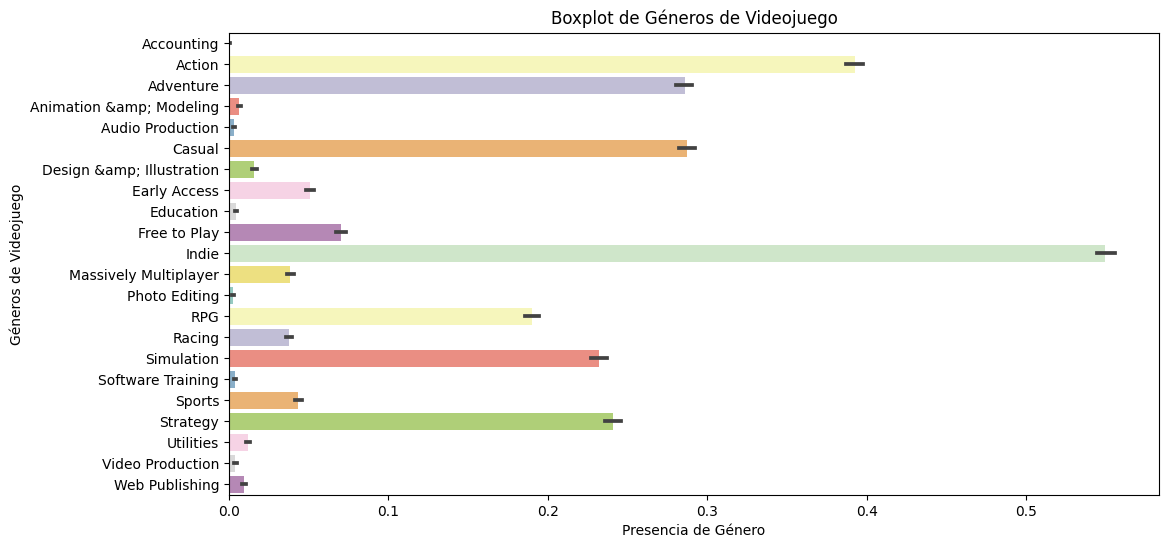

In [ ]:
# En la variable géneros asignar todos géneros de videojuegos
generos = games_df[['Accounting', 'Action', 'Adventure', 'Animation &amp; Modeling' , 'Audio Production', 'Casual', 'Design &amp; Illustration', 'Early Access', 'Education', 'Free to Play', 'Indie', 'Massively Multiplayer', 'Photo Editing', 'RPG', 'Racing', 'Simulation', 'Software Training', 'Sports', 'Strategy', 'Utilities', 'Video Production', 'Web Publishing']]

# Crear un barplot que muestre la presencia de géneros en los videojuegos
plt.figure(figsize=(12, 6))
sns.barplot(data=generos, orient="h", palette="Set3")
plt.xlabel('Presencia de Género')
plt.ylabel('Géneros de Videojuego')
plt.title('Boxplot de Géneros de Videojuego')
plt.show()

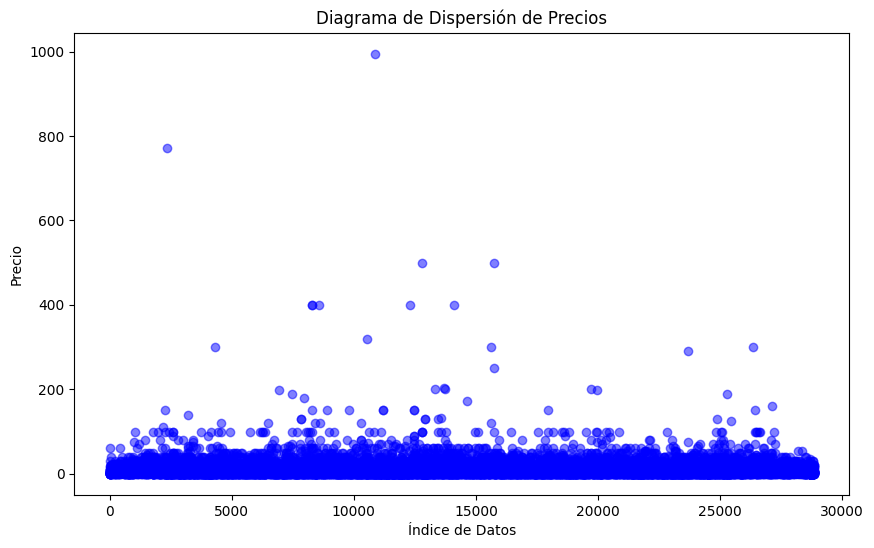

In [ ]:
# Crear un gráfico de dispersión que muestre los precios de los videojuegos
precios = games_df['price']
plt.figure(figsize=(10, 6))
plt.scatter(range(len(precios)), precios, alpha=0.5, color='b')
plt.xlabel('Índice de Datos')
plt.ylabel('Precio')
plt.title('Diagrama de Dispersión de Precios')
plt.show()

<ipython-input-57-fe44f92c4d15>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = games_df.corr()


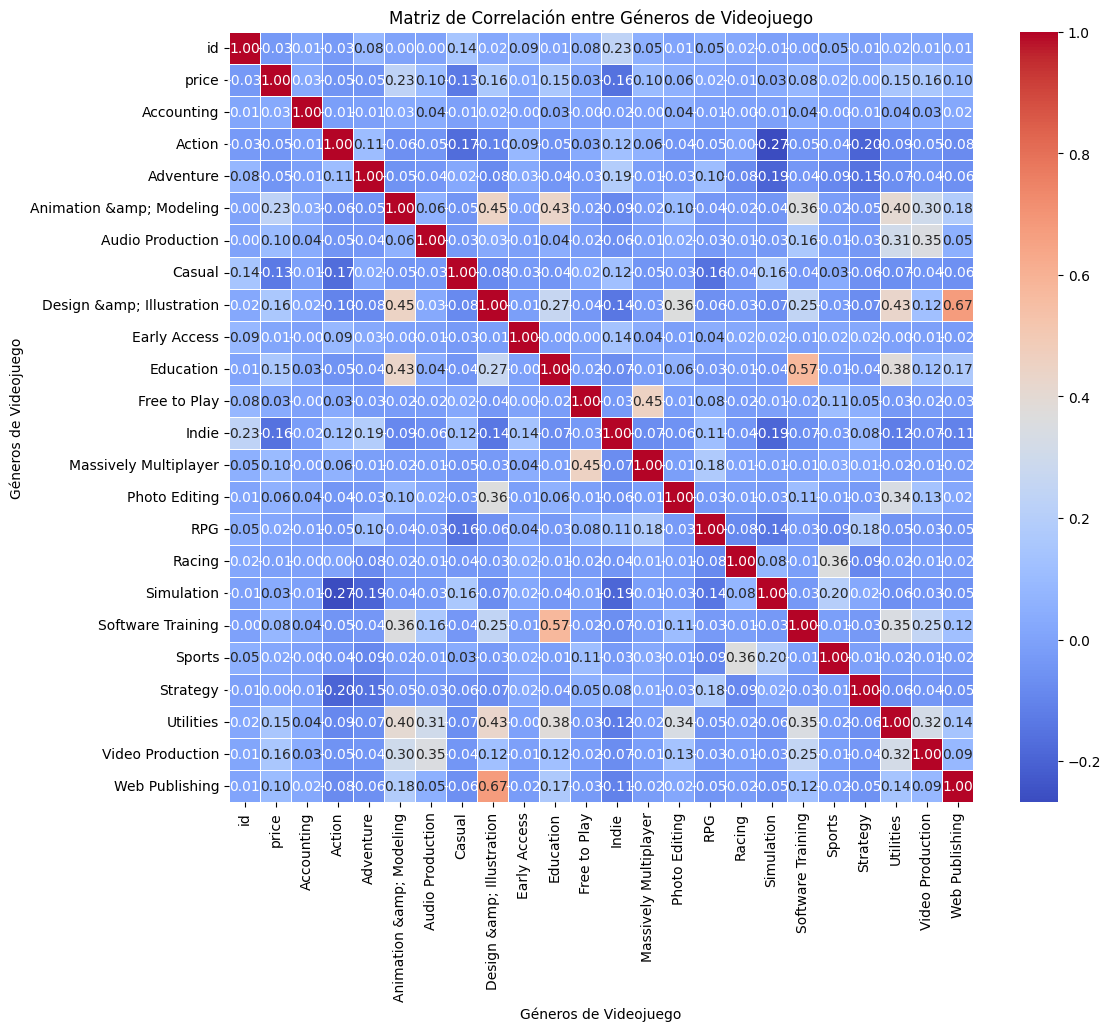

In [ ]:
# Graficar matriz de correlación para ver precios según género
# Calcular la matriz de correlación
correlation_matrix = games_df.corr()
plt.figure(figsize=(12, 10))

# Crea un mapa de calor de la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Añade etiquetas y título
plt.title('Matriz de Correlación entre Géneros de Videojuego')
plt.xlabel('Géneros de Videojuego')
plt.ylabel('Géneros de Videojuego')

# Ajusta las etiquetas del eje x y y para que sean más legibles
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Muestra la matriz de correlación
plt.show()

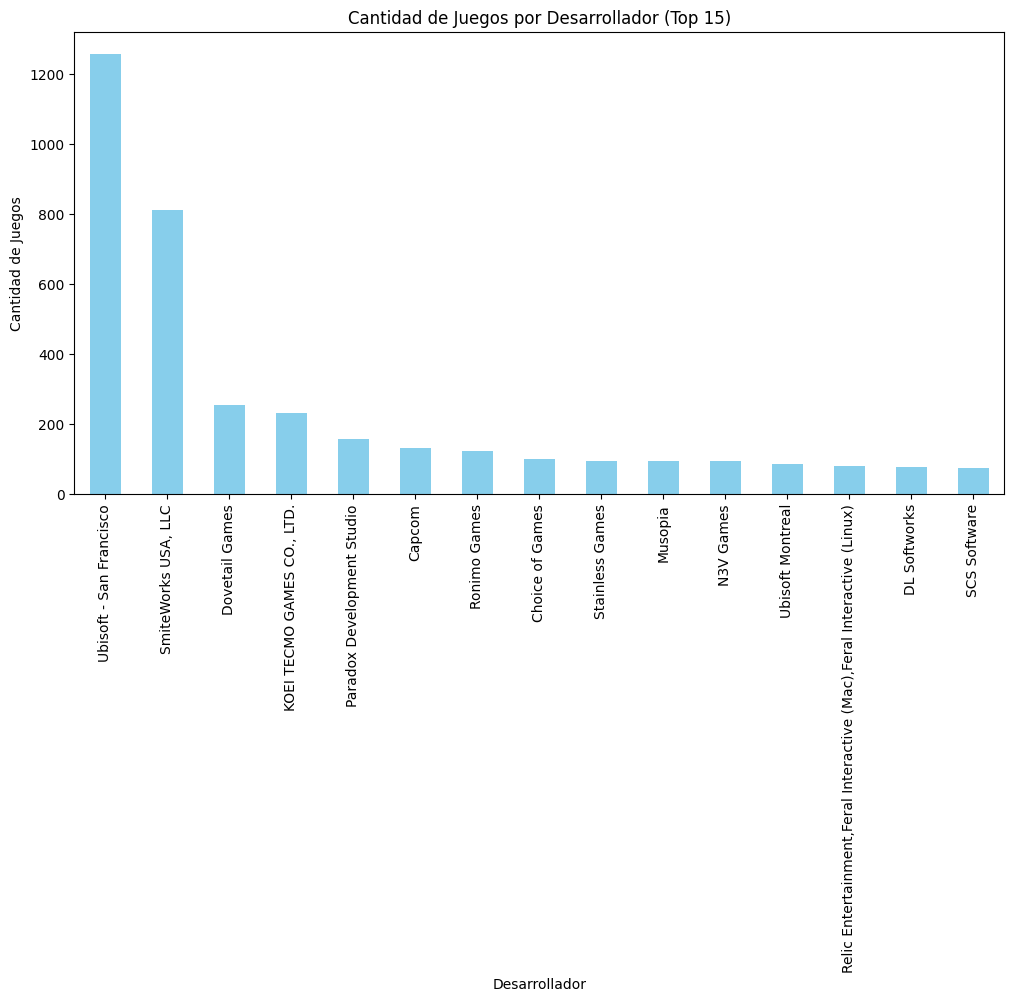

In [ ]:
# Generar un gráfico de barras para contar juegos por desarrollador
# Contar la cantidad de juegos por desarrollador
desarrolladores_count = games_df['developer'].value_counts()

# Limitar el número de desarrolladores en el gráfico a 15
top_desarrolladores = desarrolladores_count.head(15)

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
top_desarrolladores.plot(kind='bar', color='skyblue')
plt.xlabel('Desarrollador')
plt.ylabel('Cantidad de Juegos')
plt.title('Cantidad de Juegos por Desarrollador (Top 15)')
plt.xticks(rotation=90)
plt.show()